In [ ]:
# Install Ultralytics (YOLOv8)
!pip install ultralytics opencv-python-headless matplotlib numpy

# Import
from ultralytics import YOLO
import cv2
import numpy as np
import matplotlib.pyplot as plt


   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.0/1.0 MB 18.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 363.4/363.4 MB 4.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 13.8/13.8 MB 92.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 24.6/24.6 MB 28.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 883.7/883.7 kB 43.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 664.8/664.8 MB 2.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 211.5/211.5 MB 6.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 56.3/56.3 MB 12.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 127.9/127.9 MB 7.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 207.5/207.5 MB 6.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 188.7/188.7 MB 6.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 21.1/21.1 MB 79.5 MB/s eta 0:00:00
  Attempting uninstall: nvidia-nvjitlink-cu12


In [ ]:
# This is the code for running this notebook in Google Colab - This section will need to be adjusted if running locally.
from google.colab import files
uploaded = files.upload()

import os
input_filename = next(iter(uploaded))
video_path = "squat_video.mp4"

# Convert if needed
if input_filename.endswith(".mov"):
    !apt-get install ffmpeg
    !ffmpeg -i {input_filename} -vcodec libx264 {video_path}
else:
    video_path = input_filename


Saving IMG_3409.MOV to IMG_3409.MOV


In [ ]:
# Load pretrained YOLOv8-pose model
model = YOLO("yolov8n-pose.pt")  # You can try yolov8m-pose.pt or yolov8l-pose.pt for better accuracy

# Helper to calculate angle between 3 points
def calculate_angle(a, b, c):
    a, b, c = np.array(a), np.array(b), np.array(c)
    radians = np.arccos(np.clip(np.dot(a - b, c - b) /
                                (np.linalg.norm(a - b) * np.linalg.norm(c - b)), -1.0, 1.0))
    return np.degrees(radians)

# Open video
cap = cv2.VideoCapture(video_path)
knee_angles, hip_angles, frame_numbers = [], [], []
frame_idx = 0

while cap.isOpened():
    ret, frame = cap.read()
    if not ret:
        break
    frame_idx += 1

    # Run YOLOv8 Pose detection
    results = model.predict(frame, verbose=False)
    if len(results[0].keypoints.xy) == 0:
        continue

    # Get keypoints for the first person
    kpts = results[0].keypoints.xy[0].cpu().numpy()

    # Extract required joints (left side)
    # COCO Index: 11=left_hip, 13=left_knee, 15=left_ankle, 5=left_shoulder
    try:
        shoulder = kpts[5]
        hip = kpts[11]
        knee = kpts[13]
        ankle = kpts[15]

        knee_angle = calculate_angle(hip, knee, ankle)
        hip_angle = calculate_angle(shoulder, hip, knee)

        knee_angles.append(knee_angle)
        hip_angles.append(hip_angle)
        frame_numbers.append(frame_idx)

    except Exception as e:
        print(f"Error in frame {frame_idx}: {e}")
        continue

cap.release()
print(f"✅ Total frames processed: {frame_idx}")
print(f"✅ Angles captured: {len(knee_angles)} frames")


✅ Total frames processed: 355
✅ Angles captured: 355 frames


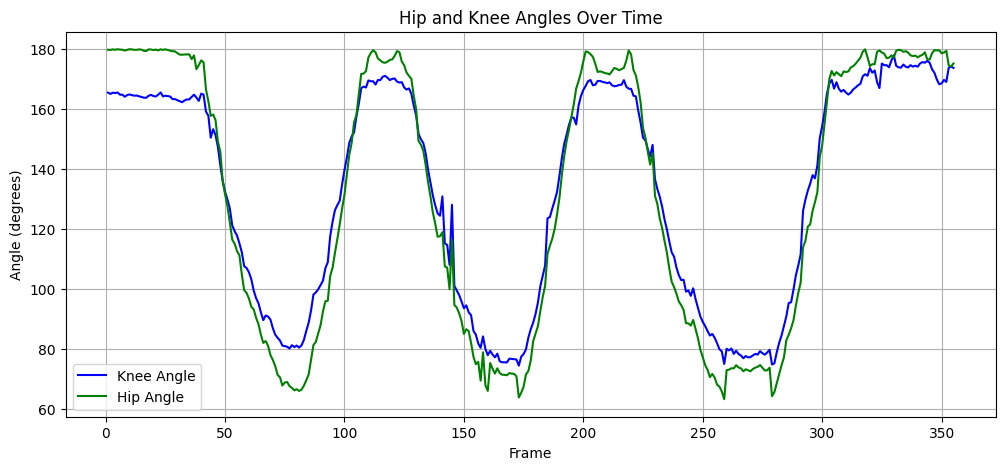

In [ ]:
plt.figure(figsize=(12, 5))
plt.plot(frame_numbers, knee_angles, label="Knee Angle", color='blue')
plt.plot(frame_numbers, hip_angles, label="Hip Angle", color='green')
plt.xlabel("Frame")
plt.ylabel("Angle (degrees)")
plt.title("Hip and Knee Angles Over Time")
plt.legend()
plt.grid(True)
plt.show()


✅ Total squats (reps) detected: 3
📍 Rep frames: [106, 198, 302]


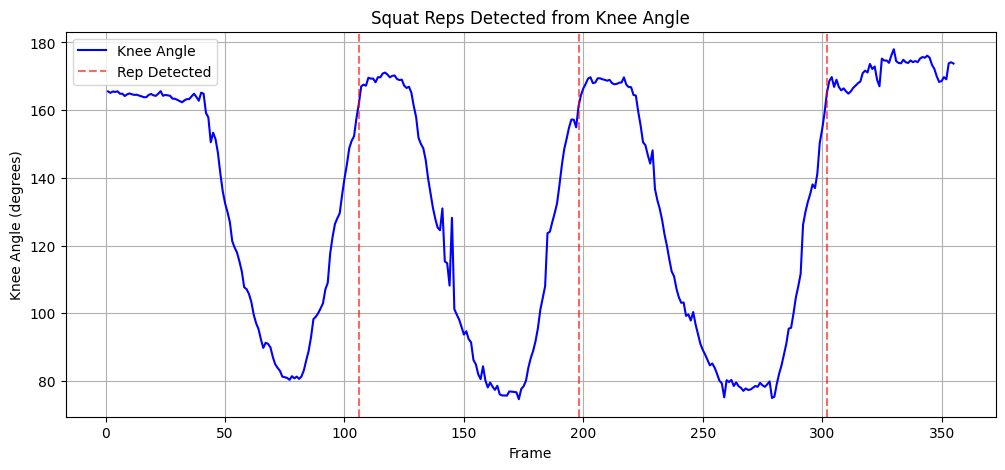

In [ ]:
# Simple squat rep detection logic
reps = []
in_rep = False
min_flexion_threshold = 110
max_extension_threshold = 160

for i in range(len(knee_angles)):
    angle = knee_angles[i]
    if not in_rep and angle < min_flexion_threshold:
        in_rep = True
    elif in_rep and angle > max_extension_threshold:
        reps.append(frame_numbers[i])
        in_rep = False

print(f"✅ Total squats (reps) detected: {len(reps)}")
print("📍 Rep frames:", reps)

# Plot with rep markers
plt.figure(figsize=(12, 5))
plt.plot(frame_numbers, knee_angles, label="Knee Angle", color='blue')
for rep_frame in reps:
    plt.axvline(x=rep_frame, color='red', linestyle='--', alpha=0.6,
                label="Rep Detected" if rep_frame == reps[0] else "")
plt.xlabel("Frame")
plt.ylabel("Knee Angle (degrees)")
plt.title("Squat Reps Detected from Knee Angle")
plt.legend()
plt.grid(True)
plt.show()


In [ ]:
from google.colab import files
uploaded = files.upload()

Saving IMG_3409.MOV to IMG_3409 (1).MOV


In [ ]:
!apt-get install ffmpeg
!ffmpeg -i IMG_3409.MOV -vcodec libx264 -crf 23 -preset slow input_squat_video.mp4

Reading package lists... Done
Building dependency tree... Done
Reading state information... Done
ffmpeg is already the newest version (7:4.4.2-0ubuntu0.22.04.1).
0 upgraded, 0 newly installed, 0 to remove and 35 not upgraded.
ffmpeg version 4.4.2-0ubuntu0.22.04.1 Copyright (c) 2000-2021 the FFmpeg developers
  built with gcc 11 (Ubuntu 11.2.0-19ubuntu1)
  configuration: --prefix=/usr --extra-version=0ubuntu0.22.04.1 --toolchain=hardened --libdir=/usr/lib/x86_64-linux-gnu --incdir=/usr/include/x86_64-linux-gnu --arch=amd64 --enable-gpl --disable-stripping --enable-gnutls --enable-ladspa --enable-libaom --enable-libass --enable-libbluray --enable-libbs2b --enable-libcaca --enable-libcdio --enable-libcodec2 --enable-libdav1d --enable-libflite --enable-libfontconfig --enable-libfreetype --enable-libfribidi --enable-libgme --enable-libgsm --enable-libjack --enable-libmp3lame --enable-libmysofa --enable-libopenjpeg --enable-libopenmpt --enable-libopus --enable-libpulse --enable-librabbitmq -

In [ ]:
import os
print(os.listdir())  # Should list 'input_squat_video.mp4'

['.config', 'IMG_5858 (1).MOV', 'IMG_5858 (2).MOV', 'input_squat_video.mp4', 'yolov8n-pose.pt', 'IMG_5858.MOV', 'sample_data']


In [ ]:
import cv2
import numpy as np
from ultralytics import YOLO

# Load the YOLOv8 pose model
model = YOLO("yolov8n-pose.pt")  # Change to yolov8m/l/x-pose.pt for better accuracy

# Helper function to calculate joint angle between 3 points
def calculate_angle(a, b, c):
    a, b, c = np.array(a), np.array(b), np.array(c)
    radians = np.arccos(np.clip(np.dot(a - b, c - b) /
                                (np.linalg.norm(a - b) * np.linalg.norm(c - b)), -1.0, 1.0))
    return np.degrees(radians)

# Load the input video
video_path = "input_squat_video.mp4"
cap = cv2.VideoCapture(video_path)

# Try to read initial frame for video dimensions
sample_frame = None
for _ in range(10):
    ret, sample_frame = cap.read()
    if ret and sample_frame is not None:
        break

if sample_frame is None or not ret:
    print("❌ Failed to read a frame from the video.")
    cap.release()
    exit()

height, width = sample_frame.shape[:2]
fps = cap.get(cv2.CAP_PROP_FPS) or 30

# Re-open video for full processing
cap.release()
cap = cv2.VideoCapture(video_path)

# Setup video writer
output_path = "output_annotated_squat.mp4"
out = cv2.VideoWriter(output_path,
                      cv2.VideoWriter_fourcc(*"mp4v"),
                      fps, (width, height))

if not out.isOpened():
    print("❌ Failed to initialize output video writer.")
    cap.release()
    exit()

# Store angles to compute min/max
knee_angles_all = []
hip_angles_all = []

frame_idx = 0
final_frame = None

while cap.isOpened():
    ret, frame = cap.read()
    if not ret:
        break
    frame_idx += 1
    final_frame = frame.copy()

    results = model.predict(frame, verbose=False)
    if len(results[0].keypoints.xy) == 0:
        out.write(frame)
        continue

    kpts = results[0].keypoints.xy[0].cpu().numpy()

    try:
        shoulder = kpts[5]  # left_shoulder
        hip = kpts[11]      # left_hip
        knee = kpts[13]     # left_knee
        ankle = kpts[15]    # left_ankle

        knee_angle = calculate_angle(hip, knee, ankle)
        hip_angle = calculate_angle(shoulder, hip, knee)

        knee_angles_all.append(knee_angle)
        hip_angles_all.append(hip_angle)

        # Draw joint lines
        cv2.line(frame, tuple(shoulder.astype(int)), tuple(hip.astype(int)), (255, 255, 0), 2)
        cv2.line(frame, tuple(hip.astype(int)), tuple(knee.astype(int)), (0, 255, 0), 2)
        cv2.line(frame, tuple(knee.astype(int)), tuple(ankle.astype(int)), (0, 0, 255), 2)

        # Draw joint markers
        for pt in [shoulder, hip, knee, ankle]:
            cv2.circle(frame, tuple(pt.astype(int)), 6, (0, 255, 255), -1)

        # Overlay angle values near joints
        cv2.putText(frame, f'{int(hip_angle)}', tuple(hip.astype(int) + np.array([10, -10])),
                    cv2.FONT_HERSHEY_SIMPLEX, 0.9, (255, 255, 0), 2)
        cv2.putText(frame, f'{int(knee_angle)}', tuple(knee.astype(int) + np.array([10, -10])),
                    cv2.FONT_HERSHEY_SIMPLEX, 0.9, (0, 255, 255), 2)

    except Exception as e:
        print(f"⚠️ Frame {frame_idx}: error calculating angles - {e}")

    out.write(frame)

# Overlay summary on the final frame
if final_frame is not None and len(knee_angles_all) > 0 and len(hip_angles_all) > 0:
    min_knee = np.min(knee_angles_all)
    max_knee = np.max(knee_angles_all)
    min_hip = np.min(hip_angles_all)
    max_hip = np.max(hip_angles_all)

    summary_color = (255, 255, 255)
    cv2.rectangle(final_frame, (10, 10), (450, 140), (0, 0, 0), -1)
    cv2.putText(final_frame, f"Min Knee: {int(min_knee)}", (20, 50),
                cv2.FONT_HERSHEY_SIMPLEX, 0.9, summary_color, 2)
    cv2.putText(final_frame, f"Max Knee: {int(max_knee)}", (220, 50),
                cv2.FONT_HERSHEY_SIMPLEX, 0.9, summary_color, 2)
    cv2.putText(final_frame, f"Min Hip:  {int(min_hip)}", (20, 100),
                cv2.FONT_HERSHEY_SIMPLEX, 0.9, summary_color, 2)
    cv2.putText(final_frame, f"Max Hip:  {int(max_hip)}", (220, 100),
                cv2.FONT_HERSHEY_SIMPLEX, 0.9, summary_color, 2)

    out.write(final_frame)

cap.release()
out.release()

print("✅ Processing complete. Output saved as:", output_path)


✅ Processing complete. Output saved as: output_annotated_squat.mp4
